<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BPalmas%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://raw.githubusercontent.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/master/DadosDiarios/palmasdiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,17283.0,17283.000000,8618.000000,8614.000000,8629.000000,8426.000000,7501.000000,8601.000000,8595.000000,7800.000000,0.0
mean,83033.0,600.104149,4.847819,33.786545,21.942172,6.886091,5.632636,26.944611,67.833653,1.430751,NaN
std,0.0,600.017350,12.013634,2.939402,2.195941,3.216965,3.437158,1.844051,16.671656,1.068604,NaN
min,83033.0,0.000000,0.000000,24.000000,11.500000,0.000000,0.000000,21.040000,22.000000,0.000000,NaN
25%,83033.0,0.000000,0.000000,32.000000,21.100000,4.400000,2.900000,25.700000,55.000000,0.666667,NaN
50%,83033.0,1200.000000,0.000000,33.900000,22.200000,7.700000,4.700000,26.820000,71.250000,1.200000,NaN
75%,83033.0,1200.000000,3.100000,35.700000,23.200000,9.800000,7.700000,28.040000,81.750000,1.900000,NaN
max,83033.0,1200.000000,156.500000,43.000000,30.800000,16.000000,18.800000,35.040000,98.750000,8.000540,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,83033,1993-11-24,0,NaN,NaN,NaN,4.3,NaN,NaN,NaN,NaN,NaN
1,83033,1993-11-24,1200,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,83033,1993-11-25,0,NaN,33.0,NaN,1.6,NaN,27.08,81.75,NaN,NaN
3,83033,1993-11-25,1200,NaN,NaN,25.6,NaN,NaN,NaN,NaN,NaN,NaN
4,83033,1993-11-26,0,NaN,32.4,NaN,7.3,NaN,26.46,78.75,NaN,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,8614.000000,0.0,8426.000000,7501.000000,8601.000000,8595.000000,7800.000000
mean,NaN,33.786545,NaN,6.886091,5.632636,26.944611,67.833653,1.430751
std,NaN,2.939402,NaN,3.216965,3.437158,1.844051,16.671656,1.068604
min,NaN,24.000000,NaN,0.000000,0.000000,21.040000,22.000000,0.000000
25%,NaN,32.000000,NaN,4.400000,2.900000,25.700000,55.000000,0.666667
50%,NaN,33.900000,NaN,7.700000,4.700000,26.820000,71.250000,1.200000
75%,NaN,35.700000,NaN,9.800000,7.700000,28.040000,81.750000,1.900000
max,NaN,43.000000,NaN,16.000000,18.800000,35.040000,98.750000,8.000540


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,8618.000000,0.0,8629.000000,0.0,0.0,0.0,0.0,0.0
mean,4.847819,NaN,21.942172,NaN,NaN,NaN,NaN,NaN
std,12.013634,NaN,2.195941,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,11.500000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,21.100000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,22.200000,NaN,NaN,NaN,NaN,NaN
75%,3.100000,NaN,23.200000,NaN,NaN,NaN,NaN,NaN
max,156.500000,NaN,30.800000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1993-11-24,NaN,4.3,NaN,NaN,NaN,NaN
1993-11-25,33.0,1.6,NaN,27.08,81.75,NaN
1993-11-26,32.4,7.3,NaN,26.46,78.75,NaN
1993-11-27,27.5,NaN,NaN,24.38,91.00,NaN
1993-11-28,32.6,7.1,NaN,26.42,78.25,NaN


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1993-11-24,1.0,NaN
1993-11-25,NaN,25.6
1993-11-26,0.0,21.7
1993-11-27,2.2,22.7
1993-11-28,0.2,22.7


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,8614.000000,8426.000000,7501.000000,8601.000000,8595.000000,7800.000000,8618.000000,8629.000000
mean,33.786545,6.886091,5.632636,26.944611,67.833653,1.430751,4.847819,21.942172
std,2.939402,3.216965,3.437158,1.844051,16.671656,1.068604,12.013634,2.195941
min,24.000000,0.000000,0.000000,21.040000,22.000000,0.000000,0.000000,11.500000
25%,32.000000,4.400000,2.900000,25.700000,55.000000,0.666667,0.000000,21.100000
50%,33.900000,7.700000,4.700000,26.820000,71.250000,1.200000,0.000000,22.200000
75%,35.700000,9.800000,7.700000,28.040000,81.750000,1.900000,3.100000,23.200000
max,43.000000,16.000000,18.800000,35.040000,98.750000,8.000540,156.500000,30.800000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1993-11-25,1.6,NaN,27.08,81.75,NaN,NaN,25.6
1993-11-26,7.3,NaN,26.46,78.75,NaN,0.0,21.7
1993-11-27,NaN,NaN,24.38,91.00,NaN,2.2,22.7
1993-11-28,7.1,NaN,26.42,78.25,NaN,0.2,22.7
1993-12-03,11.6,NaN,28.58,66.25,NaN,NaN,24.0


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1993-11-25    33.0
1993-11-26    32.4
1993-11-27    27.5
1993-11-28    32.6
1993-12-03    35.3
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,8404.000000,7486.000000,8588.000000,8574.000000,7783.000000,8590.000000,8609.000000
mean,-0.139795,-0.401299,-0.156858,0.195469,-0.642405,-0.937851,0.082196
std,0.402207,0.365757,0.263127,0.434043,0.266852,0.153740,0.227438
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.450000,-0.691489,-0.334286,-0.133550,-0.833344,-1.000000,-0.005181
50%,-0.037500,-0.500000,-0.174286,0.283388,-0.700020,-1.000000,0.108808
75%,0.225000,-0.180851,0.000000,0.557003,-0.525032,-0.960383,0.212435
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(8614, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 952.4570 - mean_absolute_error: 30.6644
Epoch 2/200
 - 1s - loss: 665.2978 - mean_absolute_error: 25.5942
Epoch 3/200
 - 1s - loss: 467.5857 - mean_absolute_error: 21.3926
Epoch 4/200
 - 1s - loss: 317.8034 - mean_absolute_error: 17.5516
Epoch 5/200
 - 1s - loss: 206.1752 - mean_absolute_error: 14.0255
Epoch 6/200
 - 1s - loss: 126.0762 - mean_absolute_error: 10.8047
Epoch 7/200
 - 1s - loss: 71.9909 - mean_absolute_error: 7.9286
Epoch 8/200
 - 1s - loss: 38.5661 - mean_absolute_error: 5.5473
Epoch 9/200
 - 1s - loss: 20.4032 - mean_absolute_error: 3.8193
Epoch 10/200
 - 1s - loss: 12.2156 - mean_absolute_error: 2.8354
Epoch 11/200
 - 

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.201914, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.201914 (0.015007) {'batch_size': 10, 'camadas': 2, 'units': 7}


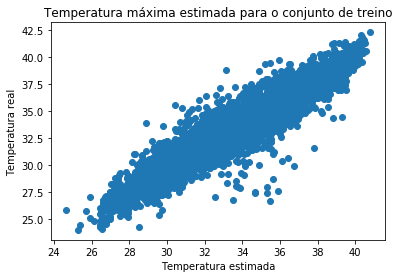

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.93108335]
 [0.93108335 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

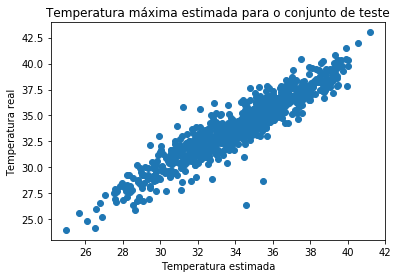

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.        0.9335022]
 [0.9335022 1.       ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.8195079524666415


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

1.2160818907877484


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1993-11-25,33.0,1.6,NaN,27.08,81.75,NaN,NaN
1993-11-26,32.4,7.3,NaN,26.46,78.75,NaN,0.0
1993-11-27,27.5,NaN,NaN,24.38,91.00,NaN,2.2
1993-11-28,32.6,7.1,NaN,26.42,78.25,NaN,0.2
1993-12-03,35.3,11.6,NaN,28.58,66.25,NaN,NaN


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1993-11-25    25.6
1993-11-26    21.7
1993-11-27    22.7
1993-11-28    22.7
1993-12-03    24.0
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,8609.000000,8416.000000,7496.000000,8597.000000,8586.000000,7794.000000,8604.000000
mean,0.030027,-0.139181,-0.401055,-0.156587,0.194594,-0.642258,-0.938001
std,0.309210,0.402090,0.365509,0.263305,0.434337,0.267169,0.153586
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.157895,-0.450000,-0.691489,-0.334286,-0.140065,-0.833344,-1.000000
50%,0.042105,-0.037500,-0.500000,-0.174286,0.283388,-0.700020,-1.000000
75%,0.231579,0.225000,-0.180851,0.000000,0.557003,-0.525032,-0.960383
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(8629, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 360.0256 - mean_absolute_error: 18.7602
Epoch 2/200
 - 1s - loss: 198.6497 - mean_absolute_error: 13.8719
Epoch 3/200
 - 1s - loss: 107.6339 - mean_absolute_error: 10.0928
Epoch 4/200
 - 1s - loss: 53.3896 - mean_absolute_error: 6.9516
Epoch 5/200
 - 1s - loss: 24.1433 - mean_absolute_error: 4.5309
Epoch 6/200
 - 1s - loss: 10.8712 - mean_absolute_error: 2.9057
Epoch 7/200
 - 1s - loss: 6.1830 - mean_absolute_error: 2.0265
Epoch 8/200
 - 1s - loss: 5.0412 - mean_absolute_error: 1.6824
Epoch 9/200
 - 1s - loss: 4.8676 - mean_absolute_error: 1.5960
Epoch 10/200
 - 1s - loss: 4.8551 - mean_absolute_error: 1.5751
Epoch 11/200
 - 1s - loss: 4.8559 - mean_absolute_error: 1.5746
Epoch 12/200
 - 1s - loss: 4.8552 - mean_absolute_error: 1.5747
Epoch 13/200
 - 1s

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.138738, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.138738 (0.048551) {'batch_size': 10, 'camadas': 2, 'units': 7}


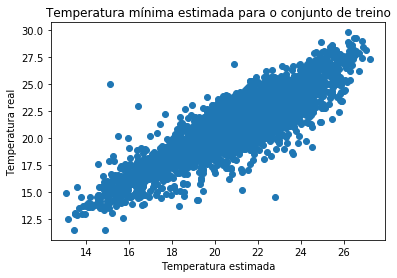

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.88285504]
 [0.88285504 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

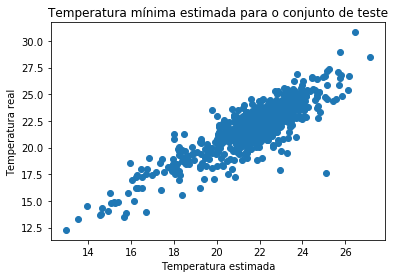

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.86772746]
 [0.86772746 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.8271762958407264


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

1.2439463543736964


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaPalmas.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaPalmas.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))